# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [7]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [32]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [33]:
function TestsSondabilite_LP(model2, x, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    if(termination_status(model2) == MOI.INFEASIBLE)#Test de faisabilite
        TA=true
        println("TA")
    elseif(objective_value(model2) <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif( prod(abs.([round.(v, digits=0) for v in value.(x)]-value.(x)) .<= fill(10^-5, size(x))) 
        ) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (objective_value(model2) >= BestProfit)
            Bestsol = value.(x)
            #BestProfit=value(benef)
            BestProfit=objective_value(model2)
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [34]:
function Borne1(listeobjs, listevals, capacite)
    r = []
    for i in 1:length(listeobjs)
        push!(r,listevals[i]/listeobjs[i])
    end
    for j in i:length(listeobjs)
            if isapprox(listevals[j]/listeobjs[j], max)
                obj = j
            end
        end
    solutions_courant = zeros(length(listeobjs))
    solutions_courant[obj] = obj/listevals[obj]
    return capacite*maximum(r), solutions_courant
end

Borne1 (generic function with 1 method)

In [46]:
function Borne2(listeobjs, listevals, capacite)
    r = []
    for i in 1:length(listeobjs)
        push!(r,listevals[i]/listeobjs[i])
    end
    r = sort(r, rev = true)
    
    sommePoids = 0
    borne = 0
    i = 1
    arret = false
    obj = 5
    
    solutions_courant = zeros(length(listeobjs))

    while !arret
        max = r[i]
        for j in i:length(listeobjs)
            if isapprox(listevals[j]/listeobjs[j], max)
                obj = j
            end
        end

        if (sommePoids + listeobjs[obj] <= capacite)
            sommePoids += listeobjs[obj]
            borne += listevals[obj]
            solutions_courant[obj] = 1
        else
            solutions_courant[obj] = i/listeobjs[obj]
            borne += r[obj]*(capacite-sommePoids)
            arret = true
        end

        i+=1
    end

    return borne, solutions_courant
end

Borne2 (generic function with 1 method)

In [36]:
function Borne(listeobjs, listevals, capacite, indice)
    borne = 0
    if indice==1
        bs, s = Borne1(listeobjs, listevals, capacite)
    else
        bs, s = Borne2(listeobjs, listevals, capacite)
    end
    return bs, s
end

Borne (generic function with 1 method)

In [55]:
function Tests_LP(valeurs_binaires_courant, BS, infaisable, bestProfit, bestSol, soluActu)
    TA, TO, TR = false, false, false
    Bestsol = bestSol
    BestProfit = bestProfit
    if(infaisable)#Test d'admissibilité
        TA=true
        println("TA")
    elseif(BS <= bestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif(prod(abs.([round.(v, digits=0) for v in soluActu]-soluActu) .<= fill(10^-5, size(soluActu))))
                #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (BS >= BestProfit)
            Bestsol = [v for v in valeurs_binaires_courant]
            #BestProfit=value(benef)
            BestProfit=BS
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

Tests_LP (generic function with 2 methods)

In [38]:

function SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  

    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end
    
    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [39]:

function optimize(price_courant,weight_courant,capacity_courant,price_constant_courant,indices_correspond_courant,valeurs_binaires_courant, indice_bs)
    stop = false
    infaisable = true
    R_courant = price_courant./weight_courant
    indicesRcourant = sortperm(R_courant,rev=true)
    solutions_courant = zeros(length(price_courant))
    cout = price_constant_courant
    if (capacity_courant < 0 || price_courant == [])
        cout = 0
        stop = true
    else
        infaisable = false
        cout, solutions_courant = Borne(weight_courant, price_courant, capacity_courant, indice_bs)
    end
    [valeurs_binaires_courant[indices_correspond_courant[i]] = trunc(Int,solutions_courant[i]) for i in 1:length(indices_correspond_courant)]
    return infaisable,cout,solutions_courant,valeurs_binaires_courant
    
end

optimize (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [67]:

function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]
    
    BestProfit=-1
    Bestsol=[]
    valeurs_binaires_courant=zeros(length(price))

    current_node_number=0
    stop = false
    price_courant = [i for i in price]
    weight_courant = [i for i in weight]
    capacity_courant = capacity
    price_constant_courant = 0
    list_indice_separation = []
    indices_correspond_courant = [i for i in 1:length(price)] 
    indice_bs = 2

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        print("Solve the LP model of the current node to compute its bound: start ... ")
        
        infaisable,cout,solutions_courant,valeurs_binaires_courant = optimize(price_courant,weight_courant,
            capacity_courant,price_constant_courant,indices_correspond_courant,valeurs_binaires_courant, indice_bs)
        
        println("... end"); 
        
        print(": Solution LP")
        if(infaisable)
            print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            [print("\t", solutions_courant[i],"=",indices_correspond_courant[i]) for i in 1:length(solutions_courant)]
        end
        println(" "); 
        
        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = Tests_LP(valeurs_binaires_courant, cout, infaisable, BestProfit, Bestsol, solutions_courant)

        is_node_sondable = TA || TO || TR

        if(!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
        end

        current_node_number = current_node_number + 1
        
        stop = current_node_number > 20
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Node number 0: 
---------------

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP	0.0=1	1.0=2	0.0=3	0.6=4 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 1


Node number 1: 
---------------

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP	0.0=1	1.0=2	0.0=3	0.6=4 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 2


Node number 2: 
---------------

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP	0.0=1	1.0=2	0.0=3	0.6=4 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 3


Node number 3: 
---------------

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP	0.0=1	1.0=2	0.0=3	0.6=4 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 4


Node number 4: 
---------------

So

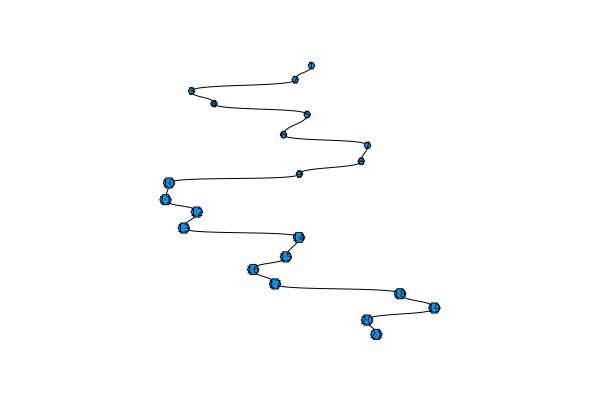

In [68]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

LoadError: UndefVarError: price not defined